Tugas

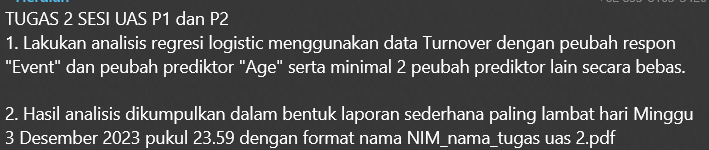

In [1]:
import sys
sys.version #Python version

'3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]'

In [2]:

#Load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use("bmh")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import category_encoders as ce

from IPython.display import clear_output

from factor_analyzer import FactorAnalyzer

from tqdm.notebook import tqdm

import random as rd

import warnings
warnings.filterwarnings('ignore')

import pickle 

## Exploration

In [3]:
#get data
df=pd.read_csv("Data/Raw_Data.csv", encoding = "ISO-8859-1")
target_names=["Yes", "N0"]
for i, j in zip(df["event (Y)"].unique(), target_names):
    df["event (Y)"][df["event (Y)"]==i]=j
df.isna().sum() #check for missing value
df.dtypes       #check for each columns type
df.describe()   #summary of the dataframe


metadata=pd.read_csv("Data/Metadata.csv")
temp=pd.DataFrame(df.dtypes.values, columns=["Object Type"])
metadata=pd.concat((metadata, temp), axis=1)
metadata    #turnover tuh macam resign kah?

,Peubah,Keterangan,Object Type
0,event (Y),Kejadian Turnover,object
1,gender,Jenis Kelamin,object
2,age,Usia,float64
3,industry,Bidang Pekerjaan,object
4,profession,Profesi,object
5,greywage,Membayar Pajak/Tidak,object
6,way,Transportasi ke Kantor,object


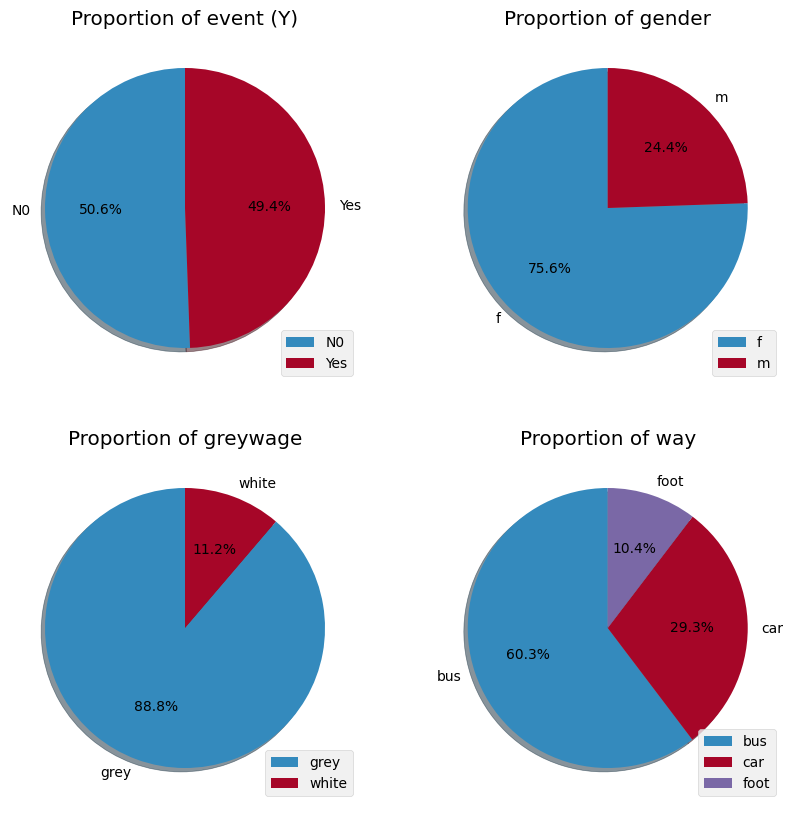

In [4]:
#get proportion of each features

fig=plt.figure(figsize=(10,10))
fig.set

counter=0
for i in [i for i in df.columns if len(df[i].unique())<10]:
    counter+=1
    ax=fig.add_subplot(2,2,counter)
    ax.pie(df[i].value_counts().values,  labels= np.unique(df[i].values), autopct='%1.1f%%', shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
    ax.set_title(f'Proportion of {i}')
    ax.legend(loc="lower right")

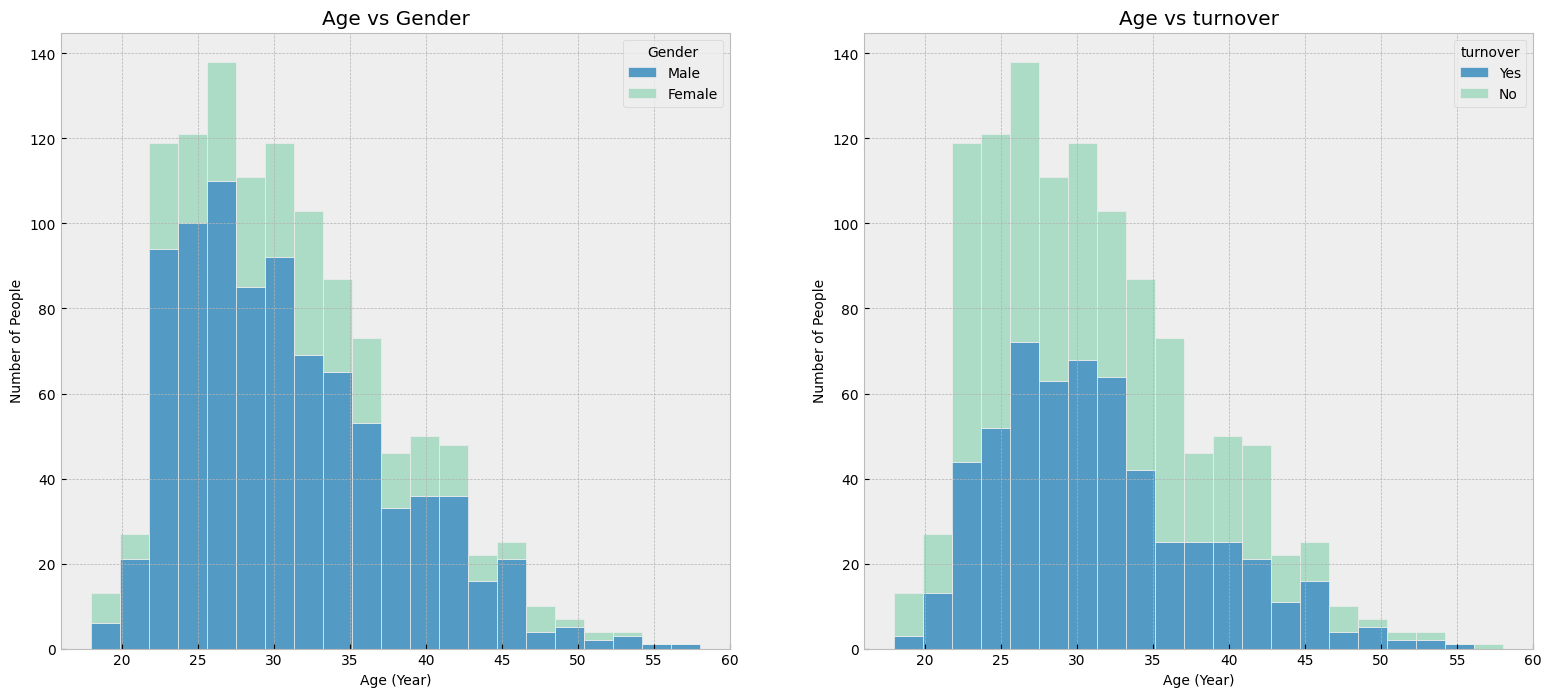

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8))

sns.histplot(data=df, x="age", hue="gender", multiple="stack", ax=ax1, palette= 'YlGnBu')
ax1.set_title('Age vs Gender')
ax1.set_xlabel('Age (Year)')
ax1.set_ylabel('Number of People')
legend1 = ax1.legend(title="Gender", labels=["Male", "Female"])

sns.histplot(data=df, x="age", hue="event (Y)", multiple="stack", ax=ax2, palette= 'YlGnBu')
ax2.set_title('Age vs turnover')
ax2.set_xlabel('Age (Year)')
ax2.set_ylabel('Number of People')
legend2 = ax2.legend(title="turnover", labels=["Yes", "No"])


<BarContainer object of 16 artists>
<BarContainer object of 16 artists>
39
23
153
75
29
20
40
10
88
5
22
9
10
22
5
8
<BarContainer object of 15 artists>
<BarContainer object of 15 artists>
400
8
10
17
31
11
5
0
7
49
2
9
4
1
4


Text(0.5, 1.0, 'Probability of turnover by profession')

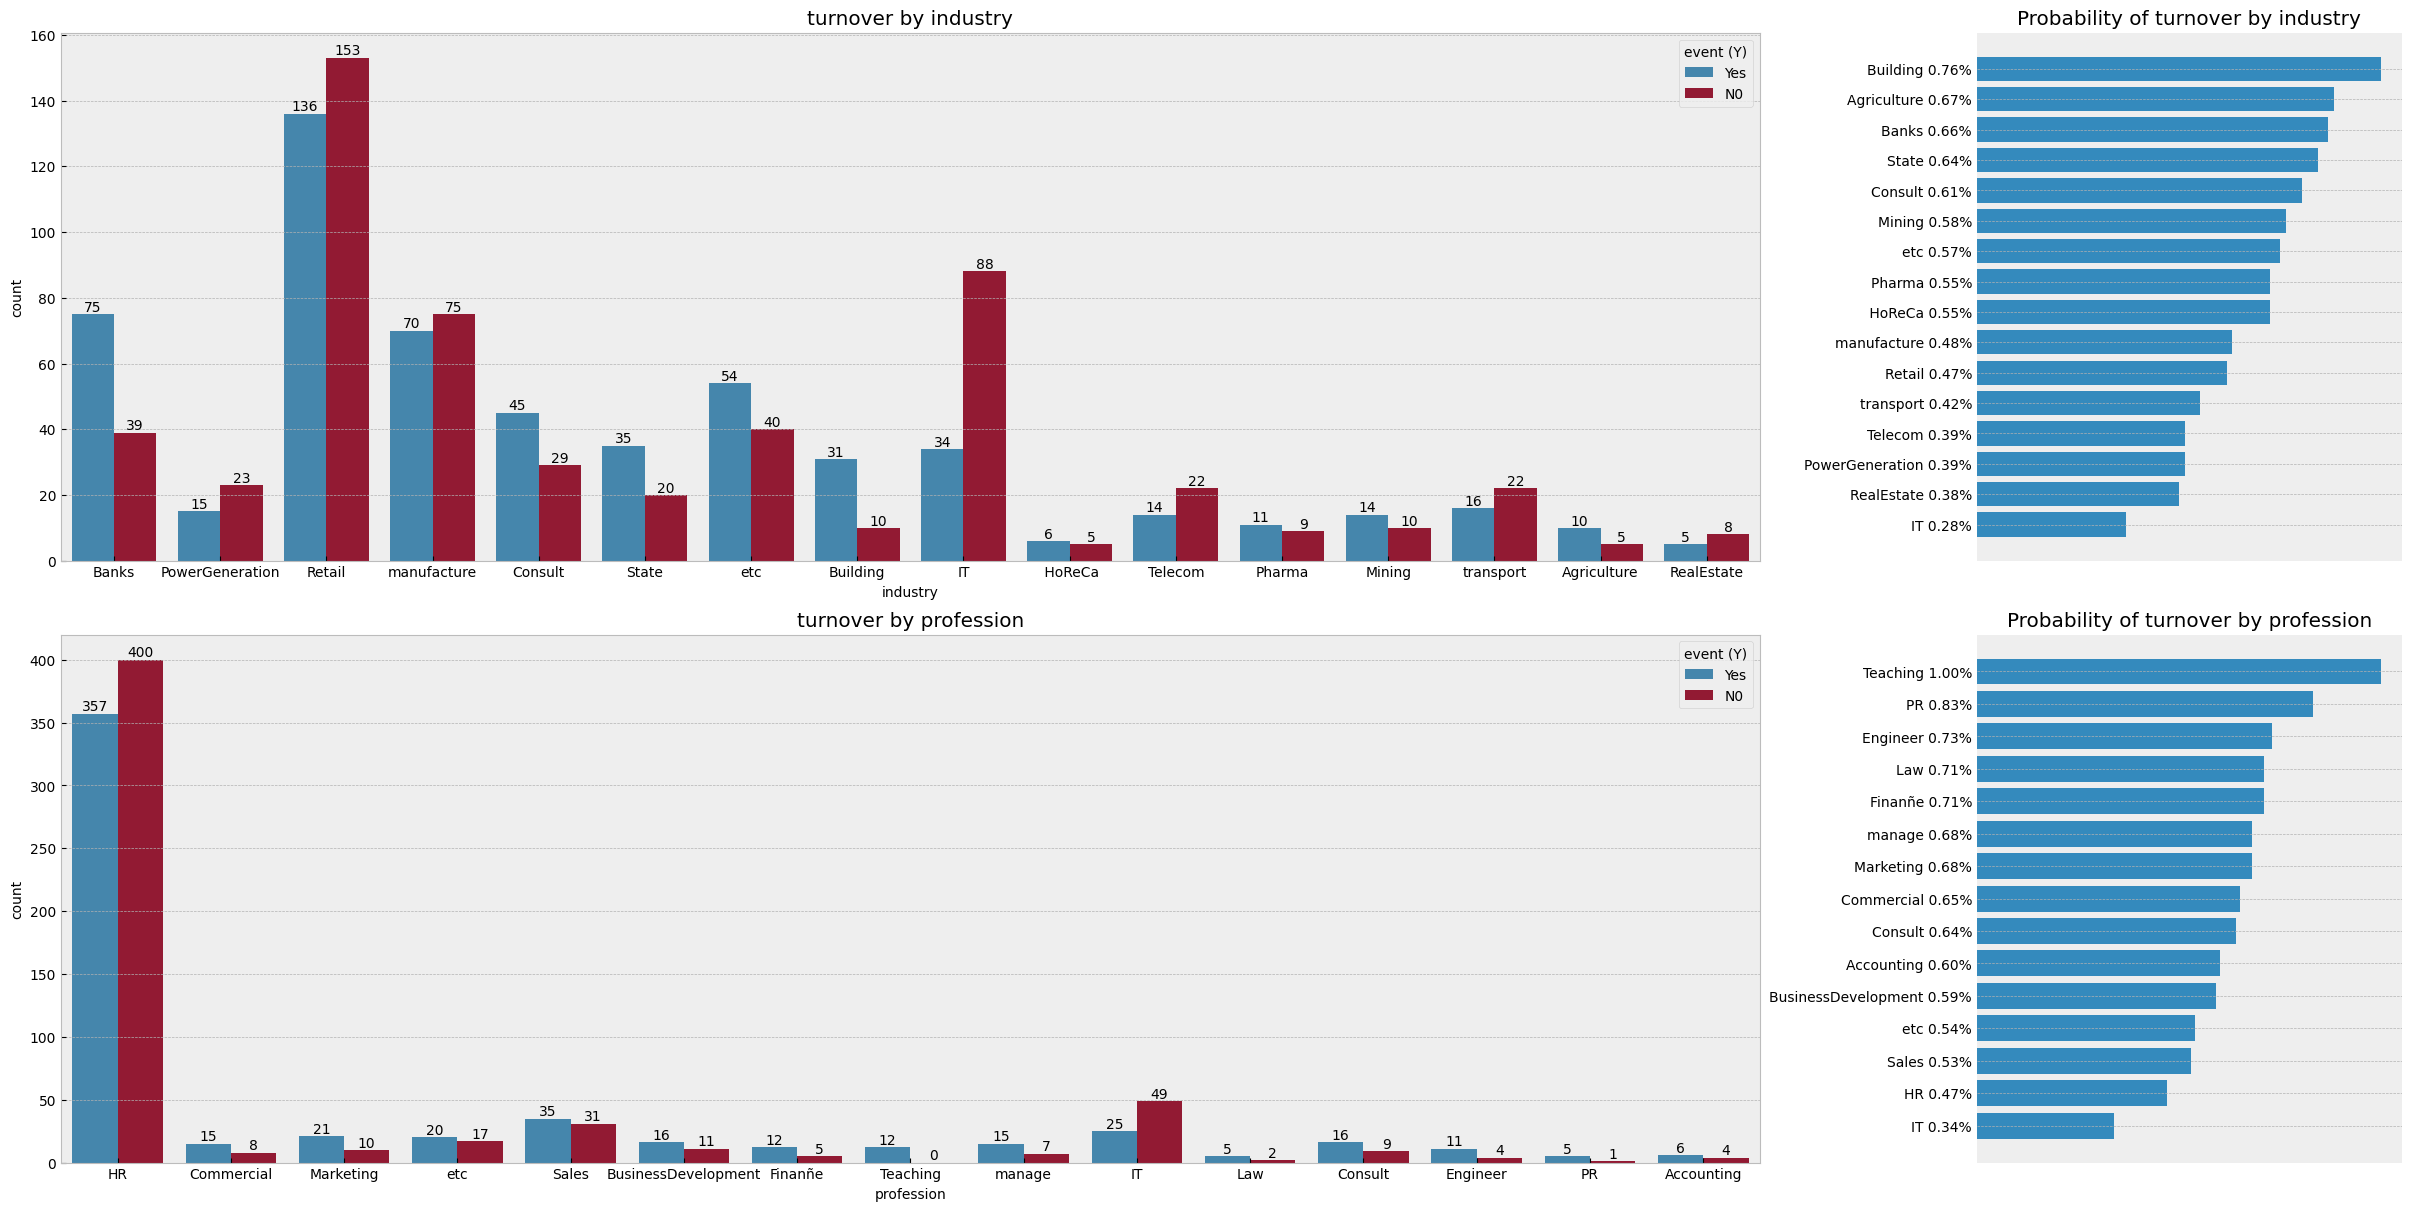

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(24,12))
ax = fig.add_gridspec(2, 5)

#1st plot
ax1 = fig.add_subplot(ax[0, 0:4])
temp=df[["event (Y)", "industry"]]
bar1=sns.countplot(data=temp,x='industry',hue="event (Y)", ax=ax1)
for i in bar1.containers:
    print(i)
    bar1.bar_label(i)
ax1.set_title("turnover by industry")


#2nd plot
ax1 = fig.add_subplot(ax[0, -1])
percentage=[]
for i in df["industry"].unique():
    yes=0;no=0
    j=temp["event (Y)"][temp["industry"]==i]
    yes=len(j[j=="Yes"]);no=len(j[j=="N0"])
    print(no)
    percentage.append([i, f'{yes/(yes+no) : .2f}'])

percentage=np.array(sorted(percentage, key=lambda x:x[1], reverse=False))

ax1.barh(percentage[:,0], percentage[:,1].astype("float"))

ax1.set_yticks(range(len(percentage[:,0])), [f'{i}{j}%' for i,j in zip(percentage[:,0], percentage[:,1])])

for spine in ax1.spines.values():
    spine.set_visible(False)
    
ax1.axes.get_xaxis().set_visible(False)
ax1.tick_params(axis="y", left=False)

ax1.set_title('Probability of turnover by industry')


#3rd plot
ax1 = fig.add_subplot(ax[1, 0:4])
temp=df[["event (Y)", "profession"]]
bar2=sns.countplot(data=temp,x='profession',hue="event (Y)", ax=ax1)
for i in bar2.containers:
    print(i)
    bar2.bar_label(i)
ax1.set_title("turnover by profession")

#4th plot
ax1 = fig.add_subplot(ax[1, -1])
percentage=[]
for i in df["profession"].unique():
    yes=0;no=0
    j=temp["event (Y)"][temp["profession"]==i]
    yes=len(j[j=="Yes"]);no=len(j[j=="N0"])
    print(no)
    percentage.append([i, f'{yes/(yes+no) : .2f}'])

percentage=np.array(sorted(percentage, key=lambda x:x[1], reverse=False))

ax1.barh(percentage[:,0], percentage[:,1].astype("float"))

ax1.set_yticks(range(len(percentage[:,0])), [f'{i}{j}%' for i,j in zip(percentage[:,0], percentage[:,1])])

for spine in ax1.spines.values():
    spine.set_visible(False)
    
ax1.axes.get_xaxis().set_visible(False)
ax1.tick_params(axis="y", left=False)

ax1.set_title('Probability of turnover by profession')

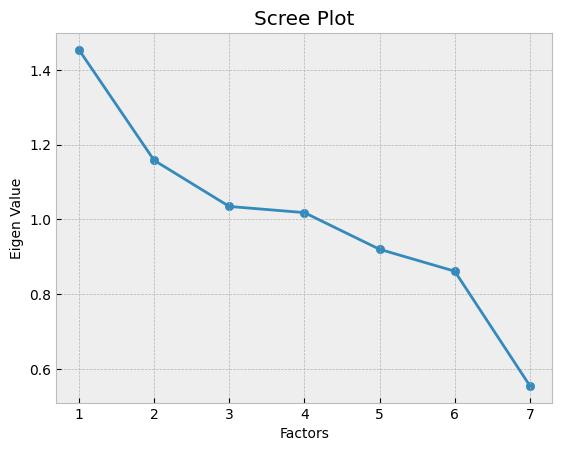

In [7]:
#Factor analysis
ordindaldf=ce.OrdinalEncoder().fit_transform(df)
fa = FactorAnalyzer(rotation = None,impute = "drop",n_factors=df.shape[1]) 
fa.fit(ordindaldf)
ev,_ = fa.get_eigenvalues()

plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid("on")

Text(0.5, 1.0, 'Dataframe reduced to 2 dimensions by PCA')

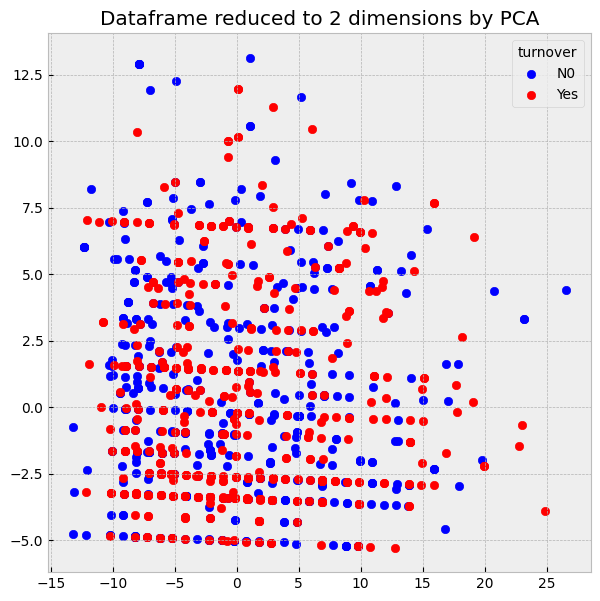

In [8]:
#PCA visualization
colour=["red", "blue"]
X=df.copy()
y=X.pop("event (Y)")
for i, j in zip(y.unique(), [1, 0]):
    y[y==i]=j

objectcolname=[i for i, j in zip(X.columns, X.dtypes) if j=="object"]

encoder=ce.OrdinalEncoder(cols=objectcolname)
X=encoder.fit_transform(X)
PCA_X=PCA(n_components=2).fit_transform(X)
clear_output()

fig, ax = plt.subplots(1,1, figsize=(7,7))
for i in [1,0]:
    ax.scatter(PCA_X[y==i,0], PCA_X[y==i,1], c=colour[i], label=target_names[i])
ax.legend(title= "turnover", loc="upper right")
ax.set_title("Dataframe reduced to 2 dimensions by PCA")

## Pre Modelling

In [9]:
X=df.copy()
y=X.pop("event (Y)")

#change event (y) from ["Yes", "No"] -> [1,0] (Binary
for i, j in zip(y.unique(), [1,0]):
    y[y==i]=j
y=y.astype("int")

#change categoric features to dummy variable
dummyencoder=ce.OneHotEncoder(cols=objectcolname).fit(X)
X=dummyencoder.transform(X)

Scaler=MinMaxScaler().fit(df["age"].values.reshape(-1,1))
df["age"]=Scaler.transform(df["age"].values.reshape(-1,1))

trainX, testX, trainy, testy= train_test_split(X,y ,train_size=0.8)

## Pembuatan Model

In [ ]:
#Model awal
model=LogisticRegression()
model.fit(trainX, trainy)

#get metrics
print(f'Train   :   {accuracy_score(trainy, model.predict(trainX))}')
print(f'Test    :   {accuracy_score(testy, model.predict(testX))}')
model.get_params()

Train   :   0.6157253599114064
Test    :   0.6415929203539823


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Hyperparameter Tuning
param_grid = { 
    'penalty': ["l1", "l2", "elasticnet"],
    'solver': ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    'multi_class': ["auto", "ovr", "multinomial"],
    'max_iter': list(range(300, 1000, 10)), 
}
counter=0;maxsearch=150
temp=[]
for i in tqdm(range(maxsearch)):
    try:
        penalty= rd.sample(param_grid["penalty"], 1)[0]
        solver= rd.sample(param_grid["solver"], 1)[0]
        multi_class= rd.sample(param_grid["multi_class"], 1)[0]
        max_iter=rd.sample(param_grid["max_iter"], 1)[0]
        model=LogisticRegression(penalty=penalty, solver=solver, multi_class= multi_class, max_iter=max_iter)
        #print(f'Penalty:    {penalty}\nsolver:      {solver}\nm_class:   {multi_class}\nmax_iter:   {max_iter}')
        model.fit(trainX, trainy)
        trainscore=accuracy_score(trainy, model.predict(trainX))
        testscore=accuracy_score(testy, model.predict(testX))
        temp.append([penalty, solver, multi_class, max_iter, trainscore, testscore])
    except:
        pass

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
tuning_data=pd.DataFrame(temp, columns=["penalty", "solver", "multi_class", "max_iter", "train_score", "test_score"])
tuning_data=tuning_data.sort_values(by="test_score",ascending=False)        #sorted by test_score
tuning_data[0:5]    #show 5 best tunings

,penalty,solver,multi_class,max_iter,train_score,test_score
34,l1,saga,auto,600,0.603544,0.659292
5,l1,saga,multinomial,510,0.603544,0.659292
6,l1,saga,multinomial,990,0.603544,0.659292
31,l1,saga,ovr,940,0.603544,0.659292
29,l1,saga,ovr,870,0.603544,0.659292


In [ ]:
#save model
model=LogisticRegression(penalty="l1", solver="saga", multi_class="auto", max_iter=600)
model.fit(trainX, trainy)


with open("models/model_scaler_encoder.pkl", "bw") as fh:
    stuffs=("Information(1: model, 2: scaler, 3: encoder)",
            model, Scaler, encoder)
    pickle.dump(stuffs, fh)

In [15]:
#load model
with open("models/model_scaler_encoder.pkl", "br") as fh:
    thing=pickle.load(fh)
model=thing[1]